# Traitement automatique des données Poids (Withings HealthMate),
# Food (MyFitnessPal), et Exercices (Polar)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn import linear_model

from zipfile import ZipFile

import datetime
import json
import re
import shutil

from tqdm import tqdm

import seaborn as sns

import ipywidgets
import os

In [2]:
# ici, aller chercher dans Download
# les fichiers commençant par data-user... , data_BEN..., etc.
# repérer les plus récents (= derniers downloads)
# et copier ces plus récents dans imports avec le nom qui va bien

# voir :
# os.listdir : liste fichiers
# os.stat_result : donne infos sur fichier x (dont date dernière modif)
# shutil.copy : copie fichier endroit X à l'endroit Y

downloads_rep = "/home/benjamin/Downloads/"
liste_downloaded_files = os.listdir(downloads_rep)

if len(liste_downloaded_files) == 0:
    raise NameError(f"Aucun fichier n'est présent dans {downloads_rep}")

In [3]:
from lib.dataeng import Etl

In [4]:
etl = Etl()
etl.repo

'/home/benjamin/Downloads/'

In [5]:
df_weight_raw = etl._extract_poids() # extrait toutes les mesures de poids


Le fichier poids le plus récent est : data_BEN_1711602041.zip, parmi :
data_BEN_1711602041.zip
data_BEN_1711174854.zip
data_BEN_1711256872.zip
data_BEN_1711256843.zip
data_BEN_1711351102.zip
data_BEN_1711427899.zip
data_BEN_1711518368.zip
data_BEN_1711256913.zip


In [6]:
df_weight = df_weight_raw.groupby(['Date']).mean()

In [7]:
df_weight.tail(15)

,Masse_Totale,Masse_Grasse,Masse_Osseuse,Masse_Musculaire,Masse_Hydrique,MG%,BMR
Date,,,,,,,
2024-03-14,72.116000,12.073333,3.002000,57.026000,40.150667,0.167414,1666.9216
2024-03-15,71.144000,11.635333,2.976000,56.514667,39.720667,0.163545,1655.3872
2024-03-16,72.585333,11.968000,3.031333,57.571333,40.721333,0.164880,1679.3344
2024-03-17,71.378667,11.607333,2.989333,56.765333,39.980667,0.162615,1661.0608
2024-03-18,71.805333,11.756667,3.003333,57.030667,40.218000,0.163729,1667.0512
2024-03-19,72.498125,11.657500,3.044375,57.782500,41.012500,0.160797,1684.1575
2024-03-20,72.203125,11.456250,3.041875,57.688125,40.971875,0.158666,1682.1325
2024-03-21,72.606875,11.938750,3.035000,57.620625,40.774375,0.164429,1680.4315
2024-03-22,71.875000,11.748125,3.006875,57.103125,40.293125,0.163451,1668.7405


In [8]:
df_weight.rolling(window=7).mean().tail(15)

,Masse_Totale,Masse_Grasse,Masse_Osseuse,Masse_Musculaire,Masse_Hydrique,MG%,BMR
Date,,,,,,,
2024-03-14,72.492714,11.660196,3.047976,57.768280,41.053863,0.160874,1683.982386
2024-03-15,72.345696,11.733458,3.035798,57.559929,40.817887,0.162222,1679.224343
2024-03-16,72.260476,11.957905,3.015810,57.270476,40.424952,0.165481,1672.535543
2024-03-17,72.073714,11.969048,3.005143,57.082952,40.228952,0.166052,1668.260800
2024-03-18,72.019810,11.935619,3.004286,57.063905,40.216667,0.165711,1667.818514
2024-03-19,72.010685,11.829929,3.009768,57.155310,40.331310,0.164275,1669.904329
2024-03-20,71.961512,11.736345,3.012607,57.196946,40.396530,0.163092,1670.863600
2024-03-21,72.031637,11.717119,3.017321,57.281893,40.485631,0.162666,1672.793586
2024-03-22,72.136065,11.733232,3.021732,57.365958,40.567411,0.162652,1674.701200


In [9]:
df_food_raw = etl._extract_food()  # calories par jour par repas


Le fichier food le plus récent est : File-Export-2020-08-03-to-2024-03-28.zip, parmi
File-Export-2020-08-03-to-2024-03-25.zip
File-Export-2020-08-03-to-2024-03-28.zip
File-Export-2020-08-03-to-2024-03-23.zip
File-Export-2020-08-03-to-2024-03-27.zip
File-Export-2020-08-03-to-2024-03-24.zip
File-Export-2020-08-03-to-2024-03-26.zip


In [10]:
df_food = df_food_raw.groupby(['Date']).sum(numeric_only=True)

In [11]:
df_food.tail(15)

,Calories,Lipides,Glucides,Proteines
Date,,,,
2024-03-13,1622.4,29.9,159.8,192.2
2024-03-14,1669.4,25.3,152.4,218.4
2024-03-15,1851.4,35.8,204.8,172.5
2024-03-16,1870.7,44.1,194.3,184.8
2024-03-17,1705.1,45.3,154.3,176.6
2024-03-18,1778.2,45.1,135.6,208.6
2024-03-19,1669.2,39.4,134.1,187.5
2024-03-20,1918.0,44.7,176.6,212.6
2024-03-21,2038.8,33.3,217.0,228.9


In [12]:
df_exos_raw = etl._extract_exos()


Le fichier exercices le plus récent est : polar-user-data-export_e3d68e51-d200-4780-843d-4f6dead67311.zip, parmi :
polar-user-data-export_bd8a06c1-7cac-47fc-a1fe-71b374e61732.zip
polar-user-data-export_e3d68e51-d200-4780-843d-4f6dead67311.zip
polar-user-data-export_703c11e2-d0c0-42d0-84a6-665ce3a9f847.zip


100%|██████████| 1977/1977 [01:42<00:00, 19.26it/s]


In [13]:
df_exos_total = df_exos_raw.groupby(['exo_date']).sum(numeric_only=True)

In [14]:
df_exos_total.tail(15)

,exo_duree,exo_cals_bruts
exo_date,,
2024-03-13,1860.704,233.0
2024-03-14,3060.580,407.0
2024-03-15,1860.738,255.0
2024-03-16,0.000,0.0
2024-03-17,6360.601,657.0
2024-03-18,3165.707,311.0
2024-03-19,2280.953,283.0
2024-03-20,6474.427,631.0
2024-03-21,2280.720,268.0


In [15]:
df_exos_total.rolling(window=7).mean().tail(15)

,exo_duree,exo_cals_bruts
exo_date,,
2024-03-13,3260.941857,365.571429
2024-03-14,3372.453286,402.285714
2024-03-15,2573.197286,320.142857
2024-03-16,2350.239714,284.714286
2024-03-17,2374.743000,268.714286
2024-03-18,2826.986857,313.142857
2024-03-19,2655.611857,306.571429
2024-03-20,3314.715143,363.428571
2024-03-21,3203.306571,343.571429


In [16]:
df_all = pd.concat( [df_weight, df_food, df_exos_total], axis=1 ).sort_index()

# remplace les NaN dans les colonnes exercice par 0.0 : jour sans exercice
df_all['exo_duree'].fillna(0.0, inplace=True)
df_all['exo_cals_bruts'].fillna(0.0, inplace=True)

# drop les jours où il manque des données autres que les exercices
subset = ['Masse_Totale', 'Masse_Grasse', 'Calories']
df_all.dropna(subset = subset, inplace=True)

In [17]:
def exo_cals_nets(bmr, exo_duree, exo_cals_bruts):
    if exo_cals_bruts > 0:
        ecn = exo_cals_bruts - bmr / (24*60*60) * exo_duree
    else:
        ecn = 0.0
        
    return ecn

df_all['exo_cals_nets'] = np.where(df_all['exo_cals_bruts'] > 0, df_all['exo_cals_bruts'] - df_all['BMR'] / (24*60*60) * df_all['exo_duree'], 0 )

In [18]:
df_all['Depense_cal_totale'] = df_all['BMR'] + df_all['exo_cals_nets']
df_all['cal_deficit'] = df_all['Calories'] - (df_all['BMR'] + df_all['exo_cals_nets'])

In [19]:
df_all.tail(15)

,Masse_Totale,Masse_Grasse,Masse_Osseuse,Masse_Musculaire,Masse_Hydrique,MG%,BMR,Calories,Lipides,Glucides,Proteines,exo_duree,exo_cals_bruts,exo_cals_nets,Depense_cal_totale,cal_deficit
2024-03-13,72.547333,12.111333,3.022000,57.396667,40.515333,0.166944,1675.4176,1622.4,29.9,159.8,192.2,1860.704,233.0,196.918331,1872.335931,-249.935931
2024-03-14,72.116000,12.073333,3.002000,57.026000,40.150667,0.167414,1666.9216,1669.4,25.3,152.4,218.4,3060.580,407.0,347.952003,2014.873603,-345.473603
2024-03-15,71.144000,11.635333,2.976000,56.514667,39.720667,0.163545,1655.3872,1851.4,35.8,204.8,172.5,1860.738,255.0,219.349052,1874.736252,-23.336252
2024-03-16,72.585333,11.968000,3.031333,57.571333,40.721333,0.164880,1679.3344,1870.7,44.1,194.3,184.8,0.000,0.0,0.000000,1679.334400,191.365600
2024-03-17,71.378667,11.607333,2.989333,56.765333,39.980667,0.162615,1661.0608,1705.1,45.3,154.3,176.6,6360.601,657.0,534.715915,2195.776715,-490.676715
2024-03-18,71.805333,11.756667,3.003333,57.030667,40.218000,0.163729,1667.0512,1778.2,45.1,135.6,208.6,3165.707,311.0,249.919032,1916.970232,-138.770232
2024-03-19,72.498125,11.657500,3.044375,57.782500,41.012500,0.160797,1684.1575,1669.2,39.4,134.1,187.5,2280.953,283.0,238.538378,1922.695878,-253.495878
2024-03-20,72.203125,11.456250,3.041875,57.688125,40.971875,0.158666,1682.1325,1918.0,44.7,176.6,212.6,6474.427,631.0,504.948564,2187.081064,-269.081064
2024-03-21,72.606875,11.938750,3.035000,57.620625,40.774375,0.164429,1680.4315,2038.8,33.3,217.0,228.9,2280.720,268.0,223.641276,1904.072776,134.727224
2024-03-22,71.875000,11.748125,3.006875,57.103125,40.293125,0.163451,1668.7405,1675.8,20.9,175.1,208.6,0.000,0.0,0.000000,1668.740500,7.059500


In [20]:
df_all.rolling(window=7).mean().tail(15)

,Masse_Totale,Masse_Grasse,Masse_Osseuse,Masse_Musculaire,Masse_Hydrique,MG%,BMR,Calories,Lipides,Glucides,Proteines,exo_duree,exo_cals_bruts,exo_cals_nets,Depense_cal_totale,cal_deficit
2024-03-13,72.418048,11.538577,3.051119,57.811804,41.126530,0.159350,1684.996557,1967.928571,43.557143,197.028571,188.442857,3260.941857,365.571429,301.922288,1986.918845,-18.990274
2024-03-14,72.492714,11.660196,3.047976,57.768280,41.053863,0.160874,1683.982386,1956.442857,39.957143,195.600000,198.285714,3372.453286,402.285714,336.511939,2020.494324,-64.051467
2024-03-15,72.345696,11.733458,3.035798,57.559929,40.817887,0.162222,1679.224343,1775.742857,33.685714,177.400000,194.914286,2573.197286,320.142857,270.093062,1949.317404,-173.574547
2024-03-16,72.260476,11.957905,3.015810,57.270476,40.424952,0.165481,1672.535543,1707.557143,29.800000,172.300000,193.800000,2350.239714,284.714286,239.118883,1911.654426,-204.097283
2024-03-17,72.073714,11.969048,3.005143,57.082952,40.228952,0.166052,1668.260800,1705.971429,32.200000,169.142857,191.371429,2374.743000,268.714286,222.954013,1891.214813,-185.243385
2024-03-18,72.019810,11.935619,3.004286,57.063905,40.216667,0.165711,1667.818514,1723.342857,34.642857,164.157143,194.357143,2826.986857,313.142857,258.656732,1926.475247,-203.132389
2024-03-19,72.010685,11.829929,3.009768,57.155310,40.331310,0.164275,1669.904329,1738.057143,37.842857,162.185714,191.514286,2655.611857,306.571429,255.341816,1925.246144,-187.189002
2024-03-20,71.961512,11.736345,3.012607,57.196946,40.396530,0.163092,1670.863600,1780.285714,39.957143,164.585714,194.428571,3314.715143,363.428571,299.346135,1970.209735,-189.924021
2024-03-21,72.031637,11.717119,3.017321,57.281893,40.485631,0.162666,1672.793586,1833.057143,41.100000,173.814286,195.928571,3203.306571,343.571429,281.587460,1954.381045,-121.323902
2024-03-22,72.136065,11.733232,3.021732,57.365958,40.567411,0.162652,1674.701200,1807.971429,38.971429,169.571429,201.085714,2937.486857,307.142857,250.251881,1924.953081,-116.981652


## Visual Management et Prédictions Bayesiennes

In [21]:
columns_to_keep = ['Masse_Totale', 'Masse_Grasse', 'Masse_Musculaire', 'BMR', 'Calories', 'exo_cals_nets']

df_mg = df_all[columns_to_keep].copy()

df_mg['next_day_MT'] = df_mg['Masse_Totale'].shift(-1)
df_mg['next_day_MG'] = df_mg['Masse_Grasse'].shift(-1)
df_mg['next_day_MM'] = df_mg['Masse_Musculaire'].shift(-1)

df_mg['Proxy_Cal_Def'] = df_mg['Calories'] - df_mg['BMR'] - df_mg['exo_cals_nets']

df_mg.dropna(inplace=True)

start_date = datetime.date(year=2023, month=3, day= 1) # '2021-04-01' - début enregistrement masse musculaire en mars 2023
# end_date = '2023-12-31'

df_mg = df_mg.loc[(df_mg.index >= start_date)] # & (df_mg.index <= end_date)]

df_mg['var_MT'] = (df_mg['next_day_MT'] - df_mg['Masse_Totale']).copy()
df_mg['var_MG'] = (df_mg['next_day_MG'] - df_mg['Masse_Grasse']).copy()
df_mg['var_MM'] = (df_mg['next_day_MM'] - df_mg['Masse_Musculaire']).copy()

df_mg.drop(columns=['next_day_MT', 'next_day_MG', 'next_day_MM'], inplace=True)

df_mg

,Masse_Totale,Masse_Grasse,Masse_Musculaire,BMR,Calories,exo_cals_nets,Proxy_Cal_Def,var_MT,var_MG,var_MM
2023-03-04,70.656667,11.420000,56.258333,1649.512000,2271.1,0.000000,621.588000,1.223333,0.428571,0.755952
2023-03-05,71.880000,11.848571,57.014286,1666.678857,1774.3,353.867654,-246.246512,-0.850000,-0.924571,0.067714
2023-03-06,71.030000,10.924000,57.082000,1668.289600,1759.7,498.562450,-407.152050,1.155000,0.202667,0.904667
2023-03-07,72.185000,11.126667,57.986667,1688.860000,2516.4,979.099745,-151.559745,0.098333,-0.948333,0.970000
2023-03-08,72.283333,10.178333,58.956667,1711.468000,1658.9,336.012941,-388.580941,-0.124762,-0.044048,-0.073810
...,...,...,...,...,...,...,...,...,...,...
2024-03-22,71.875000,11.748125,57.103125,1668.740500,1675.8,0.000000,7.059500,0.400000,-0.075000,0.451250
2024-03-23,72.275000,11.673125,57.554375,1679.000500,1770.5,597.229198,-505.729698,-0.261000,0.030208,-0.277042
2024-03-24,72.014000,11.703333,57.277333,1672.710400,1606.7,217.475076,-283.485476,0.248667,-0.004000,0.240000
2024-03-25,72.262667,11.699333,57.517333,1678.168000,1707.1,0.000000,28.932000,-0.128292,0.066292,-0.182958


In [22]:
food_intake = 1650.0
exos_avg = 250.0

data_columns = [ 'Masse_Totale', 'Masse_Grasse', 'MG%', 'Masse_Musculaire' ]

horizon_past = 30 # nb jours dans le passé
horizon_futur = 30 # nb jours projection

In [23]:
# list_columns = ['Masse_Totale', 'Masse_Grasse', 'BMR', 'Calories', 'exo_cals_nets', 'Proxy_Cal_Def']
# list_columns =['BMR', 'Calories', 'exo_cals_nets', 'Proxy_Cal_Def']
list_columns =['Calories', 'exo_cals_nets', ]
X = df_mg[list_columns].to_numpy()

# y's
y = {}
y['Masse_Totale'] = df_mg['var_MT'].to_numpy()
y['Masse_Grasse'] = df_mg['var_MG'].to_numpy()
y['Masse_Musculaire'] = df_mg['var_MM'].to_numpy()

# modeles
modeles={}
scores={}
noises={}
daily_delta ={}

for name in [ 'Masse_Totale', 'Masse_Musculaire', 'Masse_Grasse']:
    brr = linear_model.BayesianRidge()
    brr.fit(X, y[name])
    modeles[name] = brr
    scores[name] = brr.score(X, y[name])
    noises[name] = np.sqrt(1/brr.alpha_)
    daily_delta[name] = brr.intercept_ + brr.coef_[0] * food_intake + brr.coef_[1] * exos_avg
    print(f'modele = {name}; score = {scores[name]:.3f}; noise = {noises[name]:.3f}; daily_delta = {daily_delta[name]:.3f}')
    
scores['MG%'] = 'n:a'

best_ever_mgp = np.min(df_all['MG%'])
date_best_ever_mgp = df_all['MG%'].idxmin()
print(f'Best ever MG% = {best_ever_mgp*100:.1f}% le {date_best_ever_mgp}')

best_ever_mg = np.min(df_all['Masse_Grasse'])
date_best_ever_mg = df_all['Masse_Grasse'].idxmin()
print(f'Best ever MG = {best_ever_mg:.1f}kg le {date_best_ever_mg}')

modele = Masse_Totale; score = 0.221; noise = 0.668; daily_delta = -0.174
modele = Masse_Musculaire; score = 0.070; noise = 0.715; daily_delta = -0.092
modele = Masse_Grasse; score = 0.141; noise = 0.419; daily_delta = -0.077
Best ever MG% = 11.3% le 2021-10-04
Best ever MG = 7.5kg le 2021-10-04


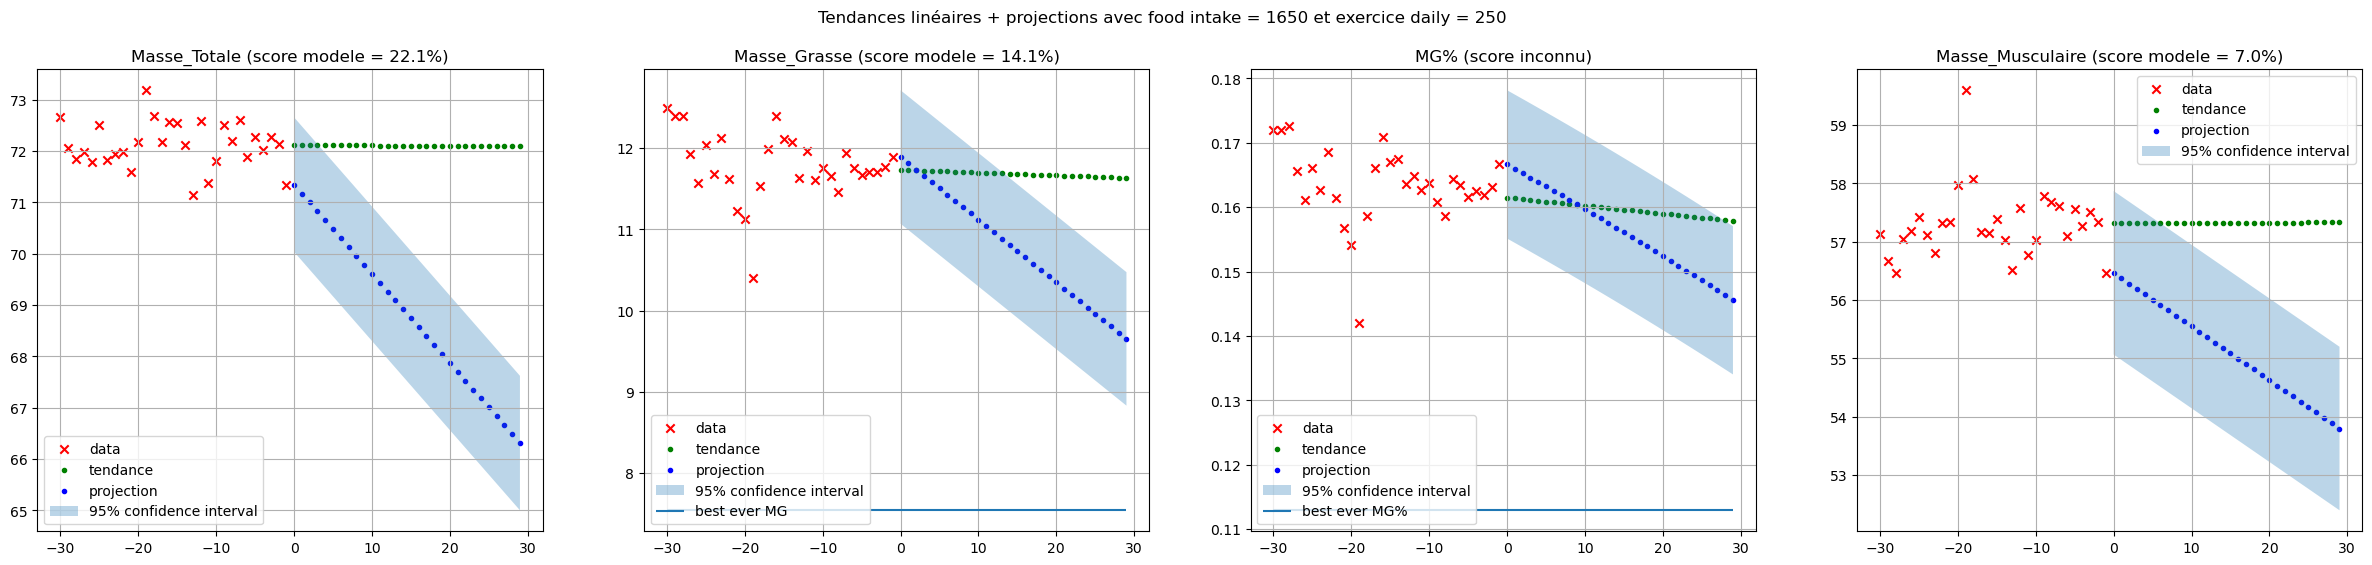

In [24]:
# Indicateurs Masse Totale, Masse Grasse, MG%, Masse Musculaire

X_past = np.array( [i for i in range(-horizon_past,0)] )
X_futur = np.array( [i for i in range(horizon_futur)] )
X = np.array([i for i in range(-horizon_past, horizon_futur)])

fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(30,6))

for i, name in enumerate(data_columns):
    
    # tendances
    brr = linear_model.BayesianRidge()
    # brr.intercept_ + brr.coef_[0] * food_intake + brr.coef_[1] * exos_avg
    data_past = df_all[name][-horizon_past:].to_numpy()
    brr.fit( X_past.reshape(-1,1), data_past )
    
    data_futur = brr.predict(X_futur.reshape(-1,1))
    
    std = np.sqrt(1/brr.alpha_)
   
    axs[i].scatter(X_past, data_past, marker='x', color='red', label='data')
    axs[i].scatter(X_futur, data_futur, marker='.', color='green', label='tendance')
    if name=='MG%':
        titre = name + ' (score inconnu)'
    else:
        titre = name + ' (score modele = ' + f'{scores[name]*100:.1f}%)'
    axs[i].set_title(titre)
    axs[i].grid(True)
    
    # predictions avec hypothèses food intake et exercices
    if name=='MG%':
        y_pred_mt = np.array([ df_all['Masse_Totale'][-1] + X_futur * daily_delta['Masse_Totale'] ]).reshape(-1,1)
        y_pred_mg = np.array([ df_all['Masse_Grasse'][-1] + X_futur * daily_delta['Masse_Grasse'] ]).reshape(-1,1)
        y_pred = np.array([ y_pred_mg[j] / y_pred_mt[j] for j in list(X_futur)]).reshape(-1,1)
        axs[i].scatter(X_futur, y_pred, marker = '.', label='projection', color='blue')
        y_std = np.array(noises['Masse_Grasse'] / df_all['Masse_Totale'][-1])  # estime une std sur MG%
    else:
        last_y = data_past[-1]
        dd = daily_delta[name]
        y_pred = np.array([ last_y + X_futur * dd ]).reshape(-1,1)
        axs[i].scatter(X_futur, y_pred, marker = '.', label='projection', color='blue')
        y_std = noises[name]
    
    y_min = np.squeeze(y_pred - 1.96 * y_std)
    y_max = np.squeeze(y_pred + 1.96 * y_std)
    axs[i].fill_between(
        X_futur,
        y_min,
        y_max,
        alpha=0.3,
        label=r"95% confidence interval",
    )
    
    if name=='MG%':
        axs[i].hlines(best_ever_mgp, xmin=X_past[0], xmax=X_futur[-1], label = 'best ever MG%')
    if name=='Masse_Grasse':
        axs[i].hlines(best_ever_mg, xmin=X_past[0], xmax=X_futur[-1], label = 'best ever MG')
        
    axs[i].legend()
    
fig.suptitle(f'Tendances linéaires + projections avec food intake = {food_intake:.0f} et exercice daily = {exos_avg:.0f}')

plt.show()

In [25]:
MAX_CAL = 1600.0
PERIODE = 45
n_jours = 15
target = (MAX_CAL*PERIODE - df_food['Calories'][n_jours-PERIODE:].sum())/n_jours
avg = df_food['Calories'][n_jours-PERIODE:].mean()

print(f'Moyenne {PERIODE-n_jours} derniers jours = {avg:.0f} kcals/jour')
print(f'Target quotidienne sur les {n_jours} prochains jours pour tenir {MAX_CAL:.0f} kcals quotidiennes = {target:.0f} kcals/jour')

Moyenne 30 derniers jours = 1780 kcals/jour
Target quotidienne sur les 15 prochains jours pour tenir 1600 kcals quotidiennes = 1241 kcals/jour


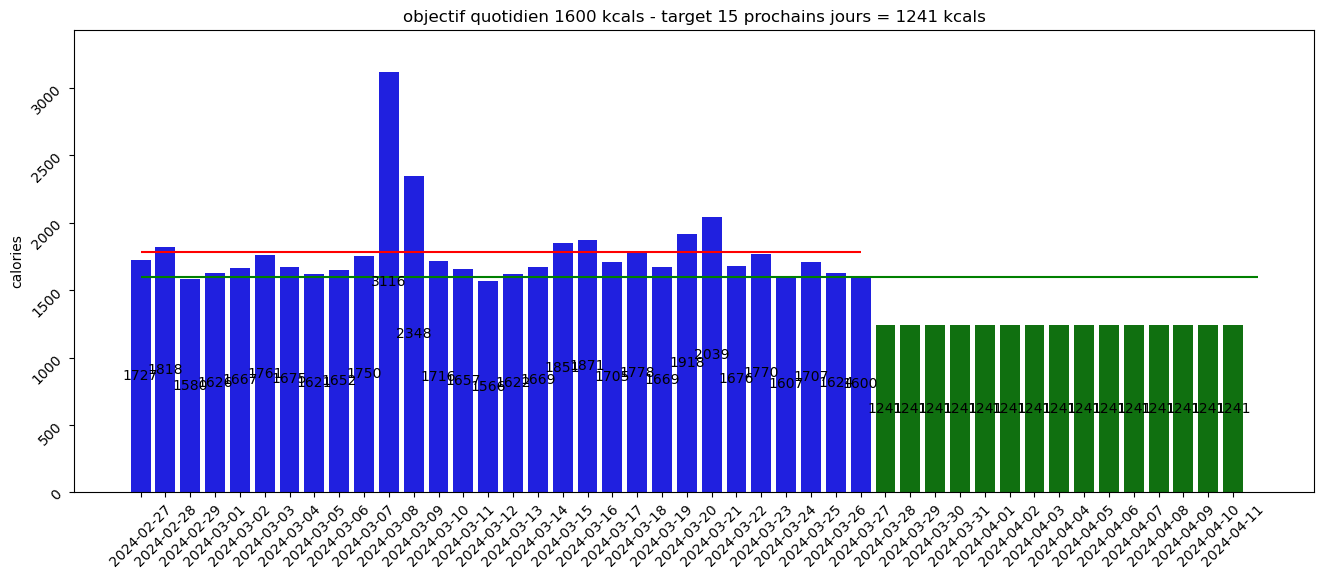

In [26]:
# plot data
fig, ax = plt.subplots(figsize=(16, 6))

tick_label = list(df_food.index[n_jours-PERIODE:]) + [ df_food.index[-1] + datetime.timedelta(days=d) for d in range(1,n_jours+1 )]
listcals = list(df_food['Calories'][n_jours-PERIODE:]) + [ target ] * n_jours

colors = [ 'blue'] * (PERIODE-n_jours) + ['green'] * n_jours
sns.barplot(x=tick_label, y=listcals, ax=ax, palette=colors)

# annotate
ax.bar_label(ax.containers[0], label_type='center', fmt="%.0f")
ax.tick_params(labelrotation=45)

# pad the spacing between the number and the edge of the figure
ax.margins(y=0.1)

ax.set_ylabel('calories')
ax.set_title(f'objectif quotidien {MAX_CAL:.0f} kcals - target {n_jours} prochains jours = {target:.0f} kcals')

ax.hlines(y=avg, xmin=0, xmax=PERIODE-n_jours-1, colors=['red'])
ax.hlines(y=MAX_CAL, xmin=0, xmax=PERIODE, colors=['green'])

plt.show()

# Graphes

In [27]:
vars = ['Masse_Grasse', 'MG%', 'Calories', 'Masse_Musculaire'] # 'Masse_Grasse', 'BMR', 'Masse_Totale', 'exo_cals_nets', 'Masse_Musculaire', 'cal_deficit',

dict_hlines = {
        'Calories' : [ (1600, 'green'), (1700, 'orange'), (1800, 'red') ],
        'cal_deficit' : [ (-500, 'green'), (-200, 'orange'), (200, 'red' ) ],
        'MG%' : [ (.14, 'green'), (.15, 'orange'), (.16,'red') ]
    }

In [28]:
def plot_general(longueur=15,
                 year=2023,
                 month=11,
                 day=1,
                #  vars = vars,
                #  dict_hlines = dict_hlines
):
    
    # vars = ['Masse_Totale', 'MG%', 'Calories', 'Depense_cal_totale', 'cal_deficit'] # 'Masse_Grasse', 'BMR',
    
    subset = ['Masse_Totale', 'Masse_Grasse'] # on permet des NaN en masse osseuse, etc en attendant d'avoir des data
    df_all2 = df_all.rolling(longueur).mean().dropna(subset = subset)
    start_date = datetime.date(year=year, month=month, day=day)

    df_all2 = df_all2[df_all2.index >= start_date]

    for v in vars:
        fig, ax = plt.subplots(figsize=(10,4))

        ax = sns.lineplot(data=df_all2, x=df_all2.index, y=v)
        ax.set_title(f"{v} (moyennes {longueur}j)") 
        ax.grid()
        ax.tick_params(axis='x', labelrotation=60)
        
        if v in dict_hlines:
            list_to_display = dict_hlines.get(v)
            for t in list_to_display:
                val = t[0]
                col = t[1]
                ax.axhline(y=val, color=col, lw=2.0)
        
    plt.plot()

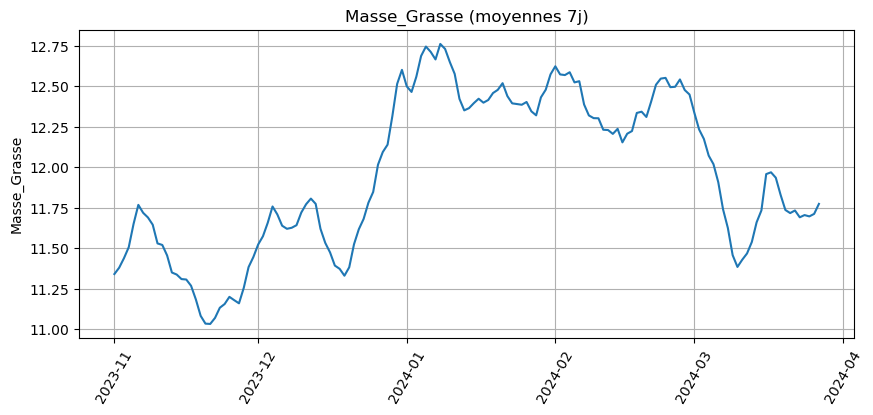

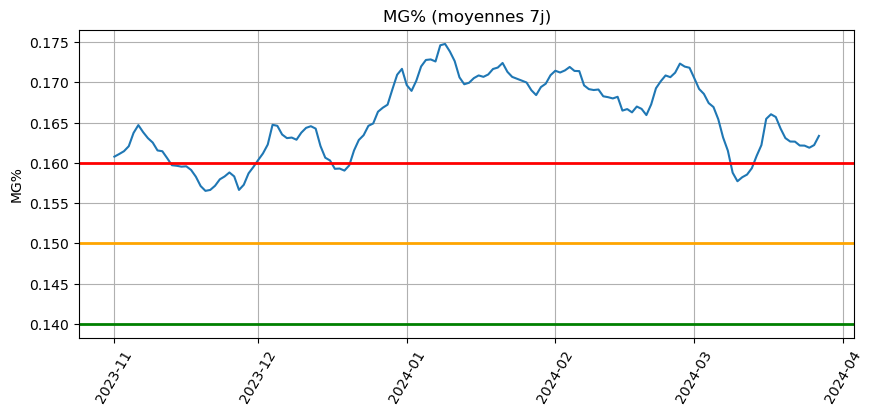

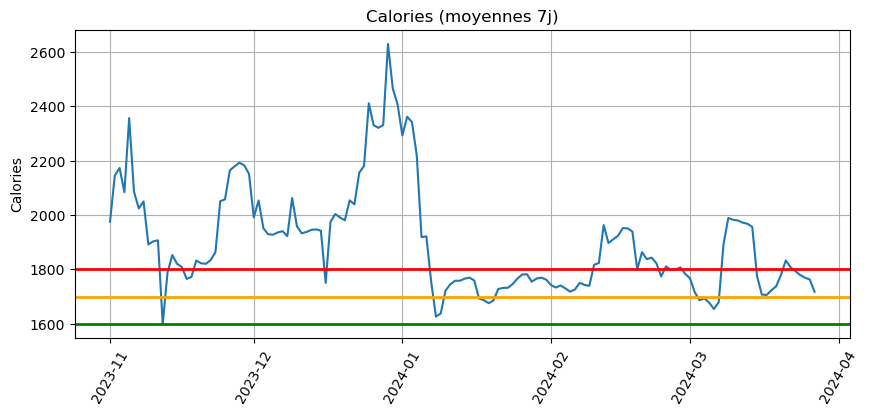

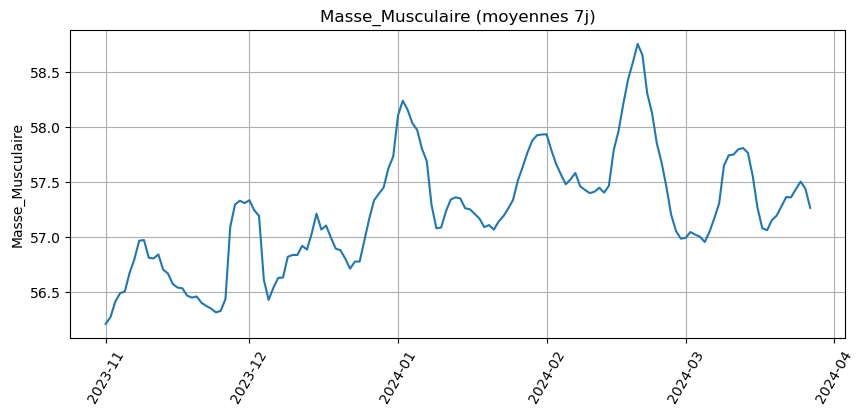

In [29]:
plot_general(longueur=7)

In [30]:
# vars = ['Masse_Grasse', 'MG%', 'Calories','Masse_Musculaire'] # 'Masse_Grasse', 'BMR', 'Masse_Totale', 'exo_cals_nets', 'Masse_Musculaire',  'cal_deficit', 

# ipywidgets.interact(plot_general, longueur=(1,90,7), year=(2020,2023,1), month=(1,12,1))

In [31]:
def plot_general2(longueur=15,
                 year=2023,
                 month=9,
                 day=1,
):
    # vars = ['Masse_Totale', 'MG%', 'BMR', 'Calories', 'cal_deficit']
    
    subset = ['Masse_Totale', 'Masse_Grasse'] # on permet des NaN en masse osseuse, etc en attendant d'avoir des data
    df_all2 = df_all.rolling(longueur).mean().dropna(subset = subset)
    start_date = datetime.date(year=year, month=month, day=day)

    df_all2 = df_all2[df_all2.index >= start_date]

    fig, ax = plt.subplots(figsize=(12,5))
    
    x = df_all2.index
    y1 = df_all2['MG%']
    ax.plot(y1, marker='.', color='red', label='MG%')
    ax.set_ylabel('MG%')
    ax.set_ylim(bottom=0.14, top=0.17)
    ax.tick_params(axis='x', labelrotation=60)
    ax.legend()
    ax.grid()
    
    y2 = df_all2['cal_deficit']
    ax2 = ax.twinx()
    ax2.plot(y2, marker='.', color='blue', label='cal_deficit')
    ax2.set_ylabel('cal_deficit')
    ax2.set_ylim(bottom=-400.0, top=500.0)
    # ax2.legend()

In [32]:
# ipywidgets.interact(plot_general2, longueur=(1,90,7), year=(2020,2023,1), month=(1,12,1), day=(1))

In [33]:
def plot_general3(longueur=15,
                 year=2023,
                 month=11,
                 day=1
):
    # vars = ['Masse_Totale', 'MG%', 'BMR', 'Calories', 'cal_deficit']
    
    subset = ['Masse_Totale', 'Masse_Grasse'] # on permet des NaN en masse osseuse, etc en attendant d'avoir des data
    df_all2 = df_all.rolling(longueur).mean().dropna(subset = subset)
    start_date = datetime.date(year=year, month=month, day=day)

    df_all2 = df_all2[df_all2.index >= start_date]

    fig, ax = plt.subplots(figsize=(12,5))
    
    x = df_all2.index
    y1 = df_all2['MG%']
    ax.plot(y1, marker='.', color='red', label='MG%')
    ax.set_ylabel('MG%')
    ax.set_ylim(bottom=0.14, top=0.17)
    ax.tick_params(axis='x', labelrotation=60)
    ax.legend()
    ax.grid()
    
    y2 = df_all2['Calories']
    ax2 = ax.twinx()
    ax2.plot(y2, marker='.', color='blue', label='cal_deficit')
    ax2.set_ylabel('Calories')
    ax2.set_ylim(bottom=1500.0, top=2500.0)
    # ax2.legend()

In [34]:
# ipywidgets.interact(plot_general3, longueur=(1,90,7), year=(2020,2023,1), month=(1,12,1), day=(1))

In [35]:
def scatter_plot(mass_interval=2.0, length=15):
    """Utility plot to scatter mass_delta over LENGTH vs average cal_deficit over LENGTH"""
    
    MASS_INTERVAL = mass_interval
    LENGTH = int(length)

    current_mass = df_all['Masse_Totale'].iloc[-1]

    df_corr = df_all[(df_all['Masse_Totale'] - current_mass) <= MASS_INTERVAL]
    df_corr = df_corr.drop(columns=['Masse_Osseuse', 'Masse_Musculaire', 'Masse_Hydrique']).copy()
    
    df_corr = df_corr.rolling(window=LENGTH).mean().dropna().copy()

    df_corr['Delta_Masse_Totale'] = (df_corr['Masse_Totale'] - df_corr['Masse_Totale'].shift(periods=LENGTH))/LENGTH*7

    df_corr.dropna(inplace=True)
    
    fig, ax = plt.subplots() #figsize=(8,8))
    cal = df_corr['cal_deficit'].to_numpy()
    delta = df_corr['Delta_Masse_Totale'].to_numpy()
    
    # print(delta)
    
    ax.scatter(x=cal, y=delta)
    ax.set_xlabel(f'average calorie deficit over {LENGTH} days')
    ax.set_ylabel(f'average weekly weight change (g) over {LENGTH} days')
    ax.grid()
    
    lr = LinearRegression()
    lr.fit(cal.reshape(-1,1), delta)
    x_cal = np.linspace(start=-500, stop=500, num=100)
    y_pred = lr.predict(x_cal.reshape(-1,1))
    
    ax.scatter(x_cal, y_pred, color='red', marker='.')
    

In [36]:
# ipywidgets.interact(scatter_plot, mass_interval=(1.0, 10.0, 0.5), length=(1, 30, 7))

In [37]:
def scatter_plot2(mass_interval=2.0, length=15):
    """Utility plot to scatter mass_delta over LENGTH vs average cal_deficit over LENGTH"""
    
    MASS_INTERVAL = mass_interval
    LENGTH = int(length)

    current_mass = df_all['Masse_Totale'].iloc[-1]

    df_corr = df_all[(df_all['Masse_Totale'] - current_mass) <= MASS_INTERVAL]
    df_corr = df_corr.drop(columns=['Masse_Osseuse', 'Masse_Musculaire', 'Masse_Hydrique']).copy()
    
    df_corr = df_corr.rolling(window=LENGTH).mean().dropna().copy()

    df_corr['Delta_Masse_Totale'] = (df_corr['Masse_Totale'] - df_corr['Masse_Totale'].shift(periods=LENGTH))/LENGTH*7

    df_corr.dropna(inplace=True)
    
    fig, ax = plt.subplots() #figsize=(8,8))
    cal = df_corr['Calories'].to_numpy()
    delta = df_corr['Delta_Masse_Totale'].to_numpy()
    
    ax.scatter(x=cal, y=delta)
    ax.set_xlabel(f'average calorie intake over {LENGTH} days')
    ax.set_ylabel(f'average weekly weight variation (g) over {LENGTH} days')
    ax.grid()
    
    lr = LinearRegression()
    lr.fit(cal.reshape(-1,1), delta)
    x_cal = np.linspace(start=1500, stop=2500, num=100)
    y_pred = lr.predict(x_cal.reshape(-1,1))
    
    ax.scatter(x_cal, y_pred, color='red', marker='.')

In [38]:
# ipywidgets.interact(scatter_plot2, mass_interval=(1.0, 10.0, 0.5), length=(1, 30, 7))

In [39]:
def scatter_plot3(mass_interval=5.0, length=15):
    """Utility plot to scatter mass_delta over LENGTH vs average cal_deficit over LENGTH"""
    
    MASS_INTERVAL = mass_interval
    LENGTH = int(length)

    current_mass = df_all['Masse_Totale'].iloc[-1]

    df_corr = df_all[(df_all['Masse_Totale'] - current_mass) <= MASS_INTERVAL]
    df_corr = df_corr.drop(columns=['Masse_Osseuse', 'Masse_Musculaire', 'Masse_Hydrique']).copy()
    
    df_corr = df_corr.rolling(window=LENGTH).mean().dropna().copy()

    df_corr['Delta_MG'] = (df_corr['Masse_Grasse'] - df_corr['Masse_Grasse'].shift(periods=LENGTH))/LENGTH*7

    df_corr.dropna(inplace=True)
    
    fig, ax = plt.subplots() #figsize=(8,8))
    cal = df_corr['Calories'].to_numpy()
    delta = df_corr['Delta_MG'].to_numpy()
    
    ax.scatter(x=cal, y=delta)
    ax.set_xlabel(f'average calorie intake over {LENGTH} days')
    ax.set_ylabel(f'average weekly fat mass variation over {LENGTH} days')
    ax.grid()
    
    lr = LinearRegression()
    lr.fit(cal.reshape(-1,1), delta)
    x_cal = np.linspace(start=1500, stop=2500, num=100)
    y_pred = lr.predict(x_cal.reshape(-1,1))
    
    ax.scatter(x_cal, y_pred, color='red', marker='.')

In [40]:
# ipywidgets.interact(scatter_plot3, mass_interval=(1.0, 10.0, 0.5), length=(1, 30, 7))